# BLU2 - Learning Notebook - Part 3 of 3 - Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
from random import seed
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = (16, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
seed(1)

% matplotlib inline

/Users/samuelhopkins/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from utils import load_airlines_series
from utils import load_electricity_consumption_series
from utils import load_shampoo_series

# In search of structure 

### White noise vs signal 

Let's get some data to start working on! 

In [3]:
mysterious_data_1 = load_electricity_consumption_series()['consumption']
mysterious_data_2 = pd.Series([gauss(0.0, 1.0) for i in range(1000)])
mysterious_data_2.name = 'White noise'
mysterious_data_2.index = pd.date_range(pd.datetime(1971, 12, 25, hour=12, minute=0), periods=1000, freq='3d')

Timeseries are sneaky things. Sometimes noise looks like data, and data looks like noise. 

A frequent problem with timeseries is answering the open, yet crucial question: _"is there any kind of signal here?"_ 

The first thing to do, as always, is to ~~run a highly complex LSTM analysis on the deep learning blockchain~~ **plot the data**


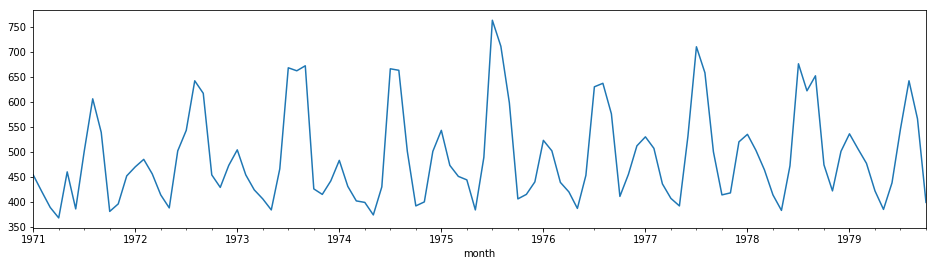

In [4]:
mysterious_data_1.plot(figsize=(16, 4));

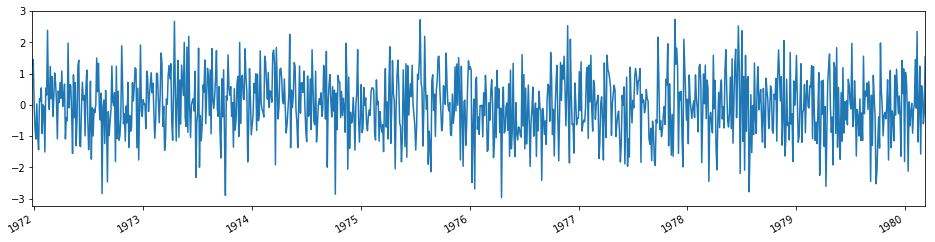

In [5]:
mysterious_data_2.plot(figsize=(16, 4));

This already gives us a visual clue that we seem to have more structure in the first one.

We can continue to search for structure by decomposing the signal, as you've learned in the previous notebook: 

##### Mysterious data 1 

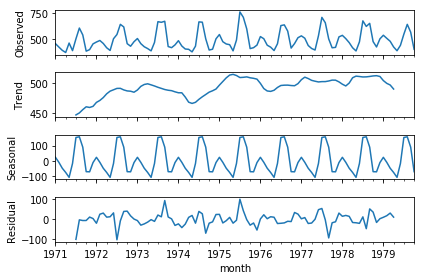

In [6]:
decomposition = seasonal_decompose(mysterious_data_1, model='additive')
decomposition.plot()
plt.show()

##### Mysterious data 2

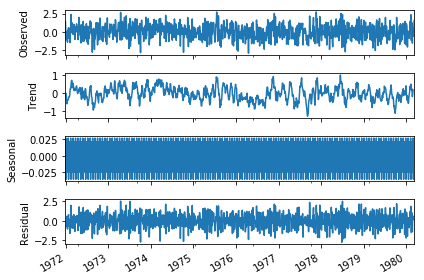

In [7]:
decomposition = seasonal_decompose(mysterious_data_2, model='additive')
decomposition.plot()
plt.show()

Well.. **_`mysterious data 2`_** seems more mysterious than **_`mysterious data 1`_**, but this is all very subjective and annoying. Maybe we have a more objective way to look for structure? 

### 1. ACF 

ACF stands for auto correlation function. 

The idea, in plain English, is very simple: _"how correlated is each datapoint, to the datapoints lagged x periods?"_

#### 1.1 ACF by hand

Original dataset: 

In [8]:
mysterious_data_1.head()

month
1971-01-01    454.0
1971-02-01    421.0
1971-03-01    389.0
1971-04-01    368.0
1971-05-01    460.0
Name: consumption, dtype: float64

Dataset, lagged by 1 period: 

In [9]:
mystery_lag_1 = mysterious_data_1.shift(1)
mystery_lag_1.head()

month
1971-01-01      NaN
1971-02-01    454.0
1971-03-01    421.0
1971-04-01    389.0
1971-05-01    368.0
Name: consumption, dtype: float64

So... the data that was at `1971-01-01` is now at `1971-02-01`, and so on and so forth. Fancy. 

Ho correlated are `mystery` and `mystery_lag_1`? 

In [10]:
mysterious_data_1.corr(mysterious_data_1.shift(1))

0.52624756902385561

Ok... how about if we lag it two times? 

In [11]:
mysterious_data_1.corr(mysterious_data_1.shift(2))

-0.14550472700327163

Negatively correlated. Let's get a bunch of these, for different values: 

In [12]:
corrs = {}
for lag in range(40):
    corrs[lag] = mysterious_data_1.corr(mysterious_data_1.shift(lag))

In [13]:
pd.Series(corrs).head()

0    1.000000
1    0.526248
2   -0.145505
3   -0.490220
4   -0.334527
dtype: float64

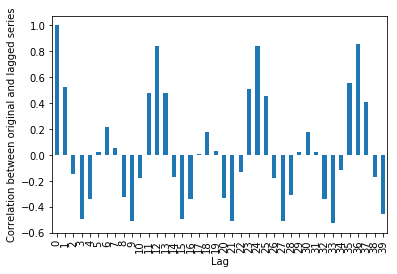

In [14]:
pd.Series(corrs).plot(kind='bar')
plt.xlabel('Lag')
plt.ylabel('Correlation between original and lagged series')
plt.show();

Wooow! We can see the structure! Every 12 months (year!) we get really high correlation, and maybe even some yearly seasons here. Cool bananas. 

#### 1.2 ACF with stats model 

ACF is so useful, that statsmodel actually comes with functions to calculate and to draw them. It also gives you something super useful, which are pre-calculated confidence intervals to get an idea of how significant the auto-correlation is:

In [15]:
# I'm allowed to import stuff in the middle of the notebook, and you aren't. Muahahaha! 
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [16]:
acf(mysterious_data_1)

array([ 1.        ,  0.52351648, -0.14388441, -0.47602432, -0.32189455,
        0.02128615,  0.20982187,  0.05729749, -0.29908263, -0.47353522,
       -0.16368264,  0.44064126,  0.77413446,  0.44222172, -0.14789621,
       -0.44085934, -0.29582641,  0.00320722,  0.15036108,  0.02568834,
       -0.27648917, -0.42271539, -0.10742918,  0.42150384,  0.69487689,
        0.37373687, -0.14384039, -0.40653345, -0.24083661,  0.01202592,
        0.13232417,  0.01821818, -0.24277425, -0.368318  , -0.07880223,
        0.38539143,  0.59142252,  0.28059546, -0.11759289, -0.30717932,
       -0.18906618])

Well that's what we just saw by hand. And the plot? 

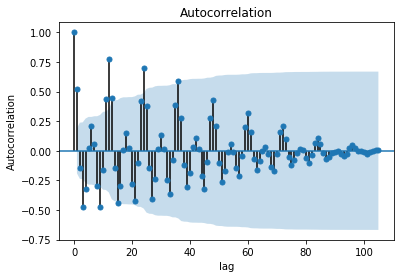

In [17]:
plot_acf(mysterious_data_1, alpha=.05)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

Preeettyyyyy.... 

The shaded area is the confidence bound. By passing the parameter `alpha=0.05` we told the plot to give us the 95% confidence interval. 

(Remember! If you're 95% confident, then you're going to be wrong once every 20 times, so take the confidence interval with that pinch of salt.)

By looking at this plot we can tell that there is some clear seasonal behavior, and that it is quite significant around the 12 mark. 

##### What happens if there is no structure? 

So, we said this helped find structure. What happens if we apply this to the sneaky looking `mysterious_data_2`? 

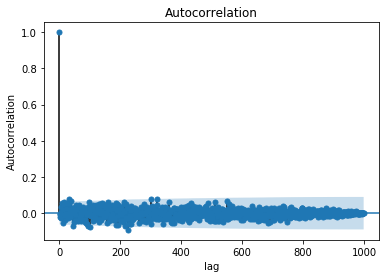

In [18]:
plot_acf(mysterious_data_2, alpha=.05)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

That, ladies and gentlemen, is how you know that noise, is noise :)

### PACF

[PACF](https://stats.stackexchange.com/questions/129052/acf-and-pacf-formula/129374#129374) stands for Partial Auto Correlation Function.

To illustrate the point of this, I'm going to plot the old ACF for `mysterious_data_1`: 

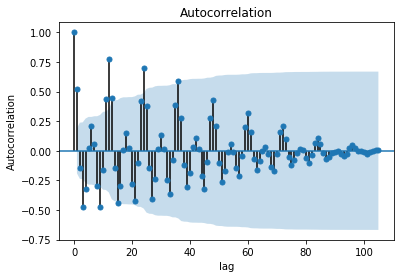

In [19]:
plot_acf(mysterious_data_1, alpha=.05)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

Isn't there something annoying about this plot? Lag 12 has a high auto-correlation. But so does lag 24. And lag 36.  So we're kind of "recycling" auto-correlation from the previous year. 

Walk into a room and tell your boss the following, and you might rightfully be laughed at:
> _"I've found something! The patterm seems to happen ever week, and every two weeks, and every 3 weeks, and every 4 weeks!"_



So what we want is to remove the autocorrelation that we've already accounted for, and plot just the "unacounted for" stuff. That's the Partial Autocorrelation Function. 

In [20]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

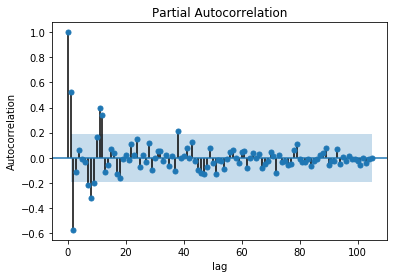

In [21]:
plot_pacf(mysterious_data_1, alpha=.05)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

Ah, much better. Easier to isolate that 12. And, by the way, why the hell are we looking at 100 months...? 

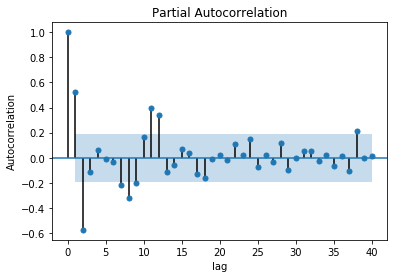

In [22]:
plot_pacf(mysterious_data_1, alpha=.05, lags=40)  # <--- 40 will be enough, thank you very much 
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

Much better. 

# In search of stationarity

What is stationarity? 

> **_"A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time."_**

Stationarity is a holy grail in timeseries, specially if you are using the type of models we will show you next. If a process is stationary, then you can make cool predictions. We can (and will) transform our timeseries until they are stationary processes.

First, let's look at a clearly non stationary timeseries 

In [23]:
sales = pd.read_csv('data/Tractor-Sales.csv')['Number of Tractor Sold']

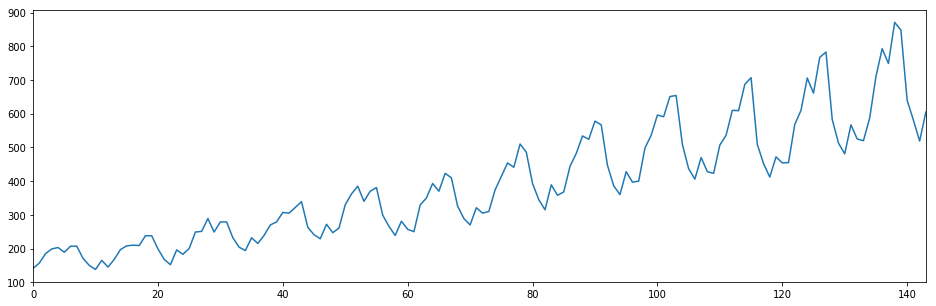

In [24]:
sales.plot(figsize=(16, 5))

#### Is the mean constant over time? 
Nop. 

#### Is the variance constant over time? 
Oh hell no.

#### Is the auto-correlation constant over time? 
Probably not...

Let's beat this timeseries into submission until it becomes stationary! 

## Removing trend 

The first thing we can clearly see in this timeseries is that it has a trend. A trivial way to remove the trend is to take the lag 1, and subtract it. In other words, instad of using the series, we will use the difference beween consecutive observations. 

Difference, you say? difference... Ah! [Diff!](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwj2kvHgif7aAhUCyRQKHRdSAkYQFggpMAA&url=http%3A%2F%2Fpandas.pydata.org%2Fpandas-docs%2Fversion%2F0.17%2Fgenerated%2Fpandas.Series.diff.html&usg=AOvVaw2vcM6MwJhG4ku5Bvpkgn8p)

### Diff 

In [25]:
sales_diff = sales.diff(periods=1)

In [26]:
sales.head(3)

0    141
1    157
2    185
Name: Number of Tractor Sold, dtype: int64

In [27]:
sales_diff.head(3)

0     NaN
1    16.0
2    28.0
Name: Number of Tractor Sold, dtype: float64

Ok, nothing in the first observation, that seems reasonable enough. How does this `sales_diff` series look? 

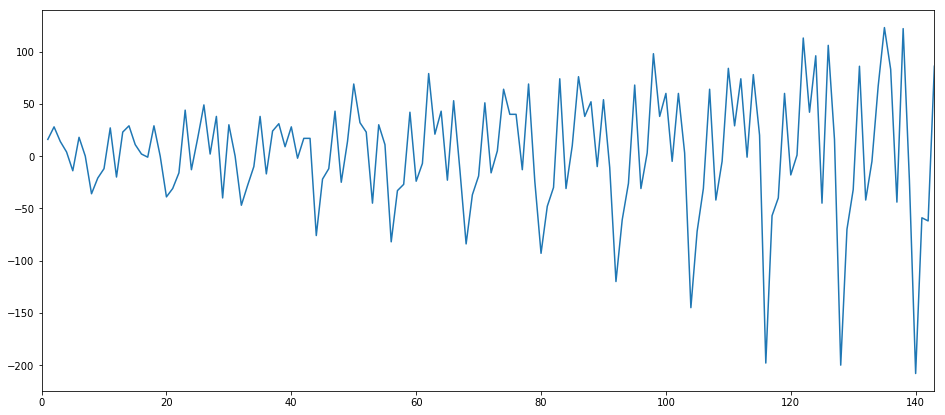

In [28]:
sales_diff.plot(figsize=(16, 7))

Better... but not stationary, because the variance is growing with time. We can take care of that by applying a log transform to the data! 

### Log 

Note: we will do the log transform first, and then the diff. The reason is that the diff has a tendency to place results at zero, which will prove problematic with the log transform. 

So please notice: this is being performed on the original dataset, not on sales_diff. 

In [29]:
sales_logged = sales.map(np.log)

What does this look like? 

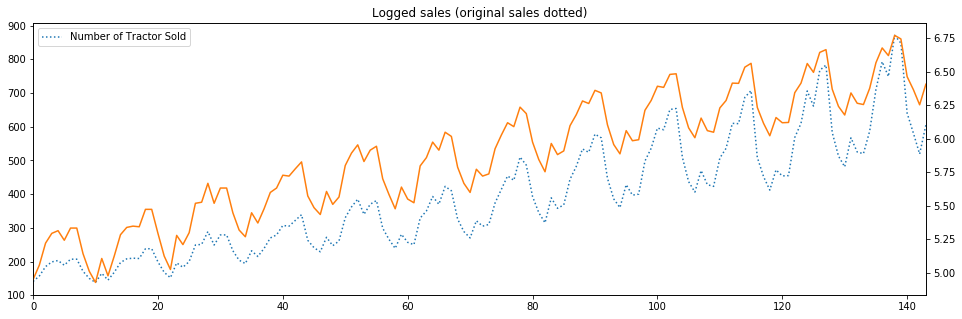

In [30]:
sales.plot(legend='Original', ls=':')
sales_logged.plot(figsize=(16, 5), secondary_y=True)
plt.title('Logged sales (original sales dotted)')
plt.show()

Notice that the variance in the original timeseries kept growing, but our logged timeseries has constant variance! 

Ok, now we can diff it. 

In [31]:
sales_logged_diff = sales_logged.diff()

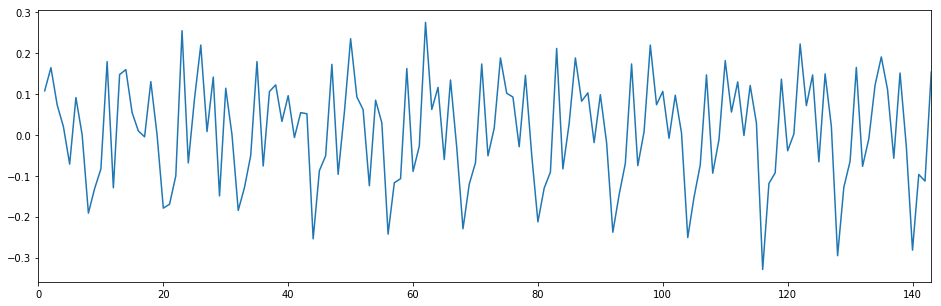

In [32]:
sales_logged_diff.plot(figsize=(16, 5))

Hmm... mean looks constant over time, variance seems constant over time... looks like we managed! 

### Other methods 

This was clearly an easy timeseries to make stationary. Most timeseries require a lot more work. There are approaches such as removing a moving average that are more powerful, and tend to work quite well. 

However, remember this: whatever transformation you do to your timeseries in your attempt to make it stationary should be one you can reverse later. If your boss asks you 
> _"How many tractors are we doing to sell in 3 weeks?"_


Answering this won't get you far: 
> _"On that week, I predict a logged diff of -0.23."_

So whenever you are transforming your timeseries, you need to keep these transformations reversible, and the more complex the transformation, the more complex it is to invert. 

### Evaluating stationarity 

Is it stationary? It... "looks stationary". 

But, as with so many things in life, when you need to quantify them, generally you'll find that [there is a way](https://i.imgflip.com/2a3kei.jpg). 

For that, we use the **[Dickey-Fuller test](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller)**: 

In [33]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

The Dickey-Fuller test has the null hypothesis that the [Unit Root](https://en.wikipedia.org/wiki/Unit_root) is present. The details of this are interesting yet out of scope, but suffice it to say for our purposes that if the unit root isn't present, the timeseries can be assumed to be stationary. 

So, for the time being, _"Unit Root is bad"_, and _"no Unit Root is good"_. If the pvalue is above a critical size, then we cannot reject that there is a unit root. 
 
 So... we want a low p value. Got that? Great. 

So let's just pass it our series... 

In [34]:
try: 
    adfuller(sales_logged_diff)
except Exception as e:
    print('NEIN! And here is why: %s' % e)
    

NEIN! And here is why: SVD did not converge


Ah damn it. The reason why we have this try catch is because you're gonna run into this at some point: 

> We forgot to get rid of our missing data. The first point, remember? 

In [35]:
sales_logged_diff.head(3)

0         NaN
1    0.107486
2    0.164110
Name: Number of Tractor Sold, dtype: float64

Trying again without the missing datapoint:

In [36]:
adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(sales_logged_diff.dropna())

Ok, I know, so many returns. It's worth taking a look at [the documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller), but for our purposes, we're going to use it in a ridiculously simple way: 

In [37]:
print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -2.68
pvalue:    0.077


The p value is low, but not as low as we'd like it to be. We can't reject that we have unit root at a 95% confidence interval, which is where we like to have these things. 

There are some things we can do. We can use a more sophisticated way of getting rid of the trend (e.g. by subtracting a rolling mean), or simply take another diff. 

In [38]:
sales_logged_and_diffed_twice = sales_logged_diff.diff().dropna() # taking a second diff 
adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(sales_logged_and_diffed_twice)
print('Statistic: %0.02f' % adfstat)
print('pvalue:    %0.03f' % pvalue)

Statistic: -8.28
pvalue:    0.000


For simplicity however, we are going to move with just one diff, into the fascinating, and confusing world of prediction. 

# ARIMA 

[ARIMA](http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html) is one of the most used models for predicting timeseries. There are more sophisticated versions that we will touch on in BLU3, but for now we'll use the plain vanilla version to develop some intuitions. 

ARIMA stands for: 

- (AR) Auto Regressive 
- (I)  Integrated 
- (MA) Moving Average

The names are, [imho](https://www.urbandictionary.com/define.php?term=IMHO), a bit misleading, let's go into them in more detail. 

About the model API, it elegantly depends only on 3 parameters: 

> `ARIMA(p,d,q)`

Notes: 
- _The results of our predictions in this notebook will suck, as we are trying to avoid adding complexity, and showcase the API._ 
- _If you want to try the hardcore version, [this article](https://people.duke.edu/~rnau/411arim.htm) has a very well made explanation for many cases of ARIMA. We are, as mentioned, going to stick to the super-basic "get your hands dirty" ARIMA._
- _If you are feeling scared with how to select hyper parameters for ARIMA remember that in the real world hyper parameter optimizers can take care of most of this. This notebook shows things as they were in the time where programmers had nothing but a dusty book, a magnetized needle and a steady hand. However getting these intuitions will help you debug and explain your models later._ 

### Auto regressive 

The first of our 3 parameters, `p`, is the "number of auto-regressive terms". 

What are auto-regressive terms? They are quite simply the lags of the dependent variable. Is the present point dependent on the previous one? On the previous two? Eight? 

In plain English, the auto-regressive model says that: 
> “The value at a particular time depends on the value at the previous times (+ error)” 

To use this model (we'll use just an AR model, and then add the other components to see the difference), we need to choose the parameter `p`, and use the model as `ARIMA(p, 0, 0)`. 

##### Choosing the hyper-parameter `p`

Choosing the parameter `p`, as with just about everything in data science, is a mixture of heuristics and experience. 

Sometimes, you have a strong business reason to say "I want to only use the previous p lags". In others, you want to use the data to tell you. 

Given that in this case we don't have much of a business intuition about tractor sales (at least I don't), we will use the PACF (partial auto-correlation function) to determine a suitable value. 

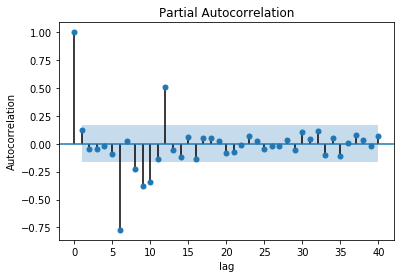

In [39]:
plot_pacf(sales_logged_diff.dropna(), alpha=.05, lags=40)  
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

What does this tell us? What we would like to see is a few components clearly go over the significance line. 

A rule of thumb is to start by testing the number of components where the significance line gets crossed, and make that our `p`. This example was chosen [quite deliberately](https://i.imgflip.com/2a3vq7.jpg) to show that sometimes this doesn't actually happen, and that sometimes these cases are a lot more ambiguous. 

So we have no guarantees that the data contains an AR process (there is some indication it doesn't), but let's experiment with the ARIMA model to see if we can spot any pattern in the AR part: 

In [40]:
model = ARIMA(sales_logged_diff.dropna().values, order=(1, 0, 0))
results = model.fit();

A few of things to note about the API:
1. We passed the data straight to the model (unlike in sklearn) 
2. We used .values to get the numpy array instead of the pandas series ([this is how we're now all feeling](https://i.imgflip.com/2a3tym.jpg))
3. We passed the order `(p, d, q)` as `(1, 0, 0)`, as we'd established that we want to try `p=1`
4. We called `fit` without any parameters (which is also different from sklearn) 
5. The model isn't fit in place, we have to grab the results with a results
6. We got some annoying FutureWarnings. Nothing to worry about, but will pollute your screen. 

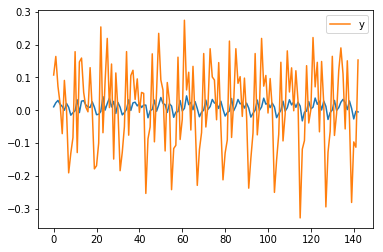

In [41]:
results.plot_predict()
plt.show()

### Integrated 

The "integrated" part of the name simply means that we take the diff between consecutive periods to make the time series stationary. We've already done this ahead of time (because we needed it for our ACF and PACF plots), but you can also leave it as a hyper parameter and tune it later. 

The name "integrated" is something that, to be completely honest, baffles me. My guess is that they didn't want to say "differentiated" because the model would then be `ARDMA`, but that isn't a bad name. At the end of the day, some would claim that the reasons [might never be clear](https://i.imgflip.com/2a3kk1.jpg). 

Anyway, to change the parameter `d`, we follow the same logic as before. Let's set `p` to 1, and try a few values of `d`: 

In [42]:
# making the plot smaller, so that the notebook doesn't seem as large an scary 
plt.rcParams["figure.figsize"] = (20,3)

In [43]:
def try_parameter_d(data, d):
    model = ARIMA(data, order=(1, d, 0))
    results = model.fit();
    results.plot_predict()
    plt.show()

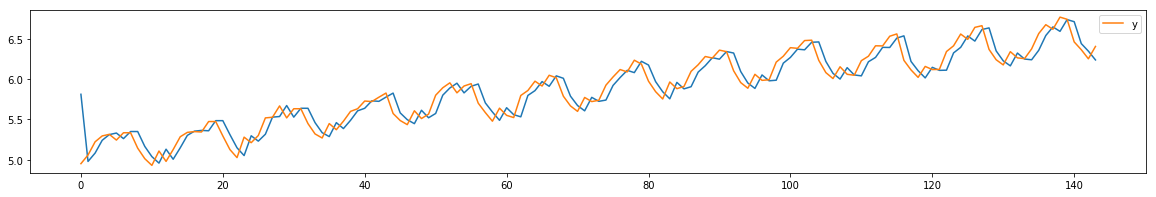

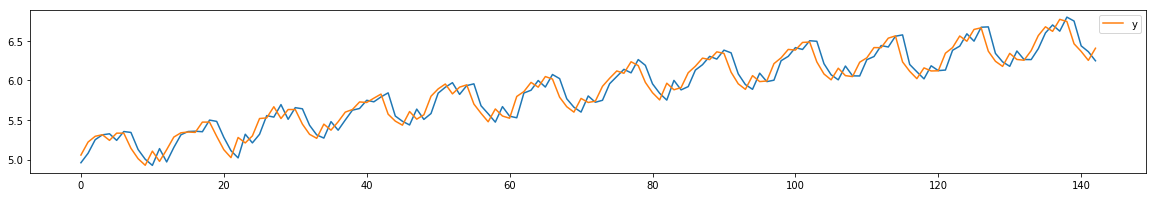

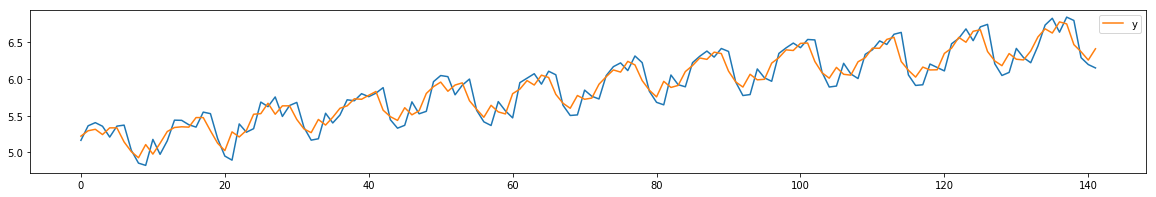

In [44]:
# notice that we are passing the original logged data, and letting d diff it as it needs
try_parameter_d(sales_logged.astype(float).values, 0)
try_parameter_d(sales_logged.astype(float).values, 1)
try_parameter_d(sales_logged.astype(float).values, 2)

### Moving Average 

The last of our 3 parameters, `q`, is the "number of moving average terms". 

The logic here is similar to the one we used for `p`, but instead of predicting values with lagged values, we are predicting errors with lagged errors. 

The MA terms are lagged forecast errors. In this model, what predicts `x(t)` is `e(t-1)`, `e(t-2)`, ..., where `e(i)` is the difference between the moving average at the ith instant and the actual value.

In plain English, the moving average model says that: 
> _“your function at a particular time is your error at that time, plus a parameter theta times your error at a previous time”_

##### Choosing the hyper-parameter `q`

Yay! Anoyher hyper parameter! 

The rule of thumb for setting `q` is to ~~`use a hyper-parameter optimizer because it's 2018, AWS is cheap and life is short`~~ use the ACF. The reasons are not trivial, and are well explained in [this fantastic StackExchange post](https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa), if you are interested in digging deeper. 

If not, just remember: 
> For `p` use the PACF  
> For `q` use the ACF. 

So, let's plot our ACF: 

In [45]:
# quick adjustment to plot sizes for clarity 
plt.rcParams["figure.figsize"] = (20,7)

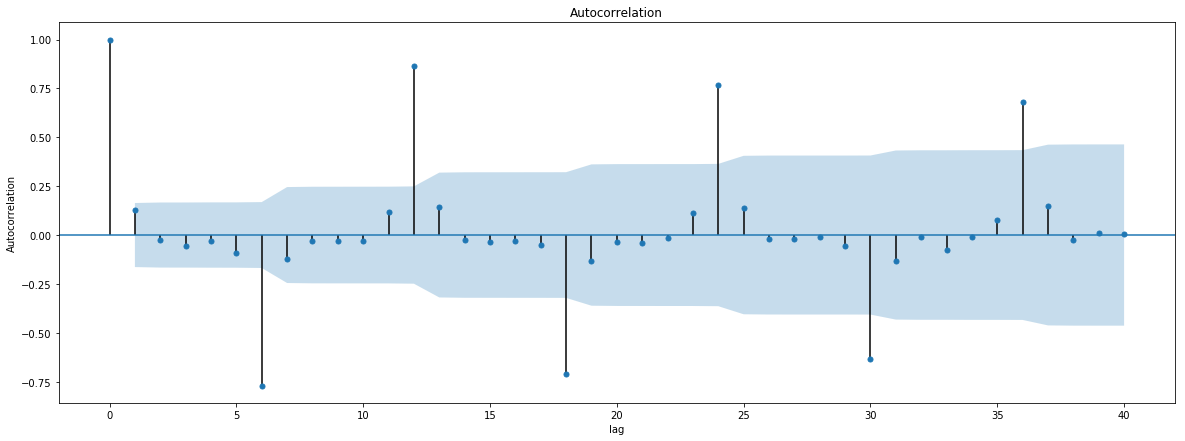

In [46]:
plot_acf(sales_logged_diff.dropna(), alpha=.05, lags=40)  
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

As before, the rule of thumb is "where we first cross the significance line", so we'll try `q`=1

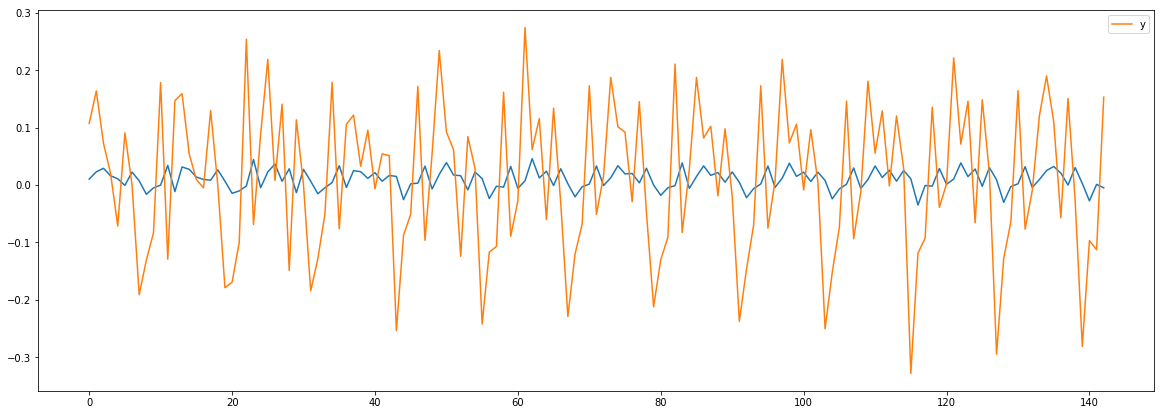

In [47]:
model = ARIMA(sales_logged_diff.dropna().values, order=(0, 0, 1))
results = model.fit();
results.plot_predict()
plt.show()

_Note: You might be wondering what metric we should be using (other than our eyes) to tell how well we're doing. We'll go into more detail in BLU3 (as this is getting very demanding already), but if you are too curious now and just can't wait, check out_ [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)

### All together 

Great, so now we know how to use the Auto Regressive model, the Moving Average model, and how to control how much differentiation goes on. It only remains to put it all together, and have some fun. 

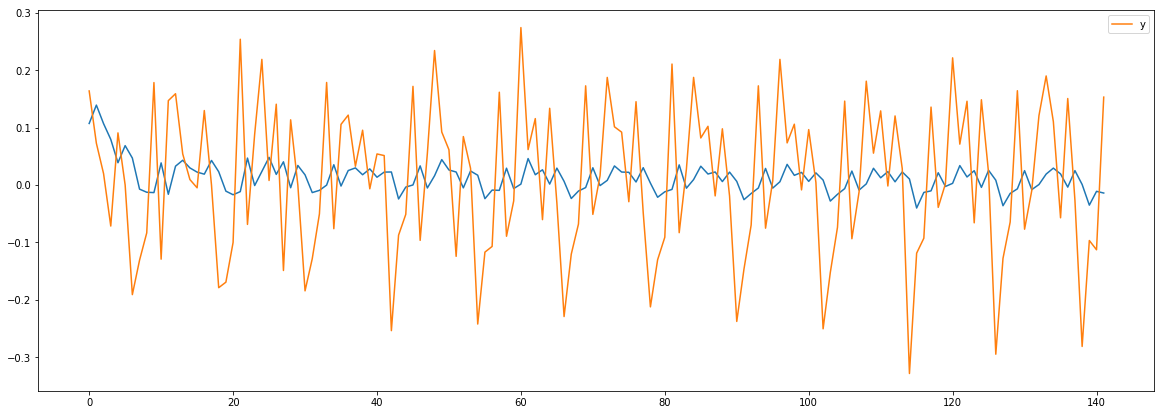

In [48]:
model = ARIMA(sales_logged_diff.dropna().values, order=(1, 1, 1))
results = model.fit();
results.plot_predict()
plt.show()

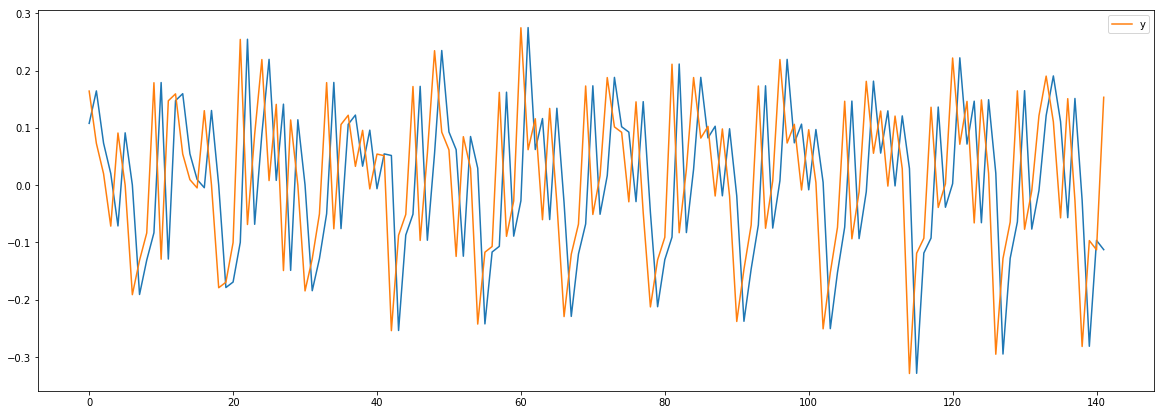

In [49]:
model = ARIMA(sales_logged_diff.dropna().values, order=(0, 1, 0))
results = model.fit();
results.plot_predict()
plt.show()

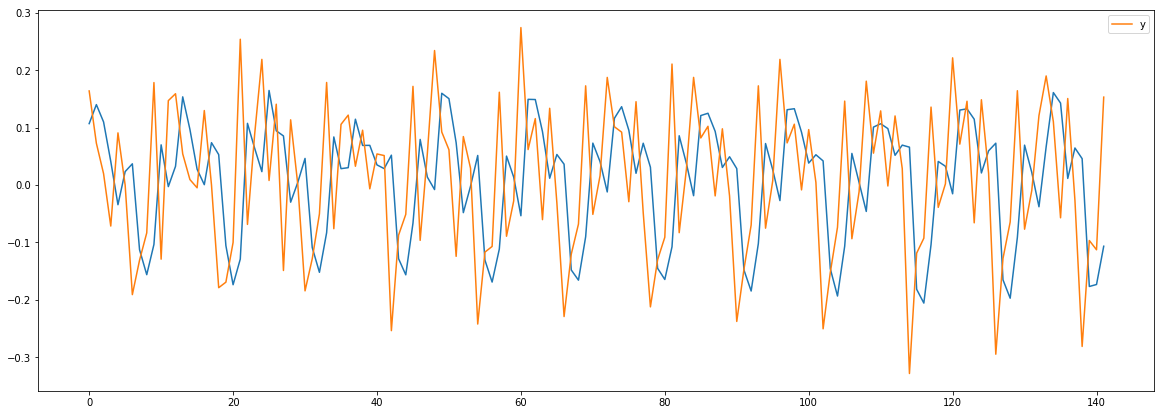

In [50]:
model = ARIMA(sales_logged_diff.dropna().values, order=(1, 1, 0))
results = model.fit();
results.plot_predict()
plt.show()

## Undoing the transformations 

One last, but critical point, is how to undo our transformations. As you might have noticed, the plots we made don't actually predict sales of tractors, they predict... some weird logged thing differentiated twice. 

### Undoing the diff 

How can we undo our diff? To take a metaphor from the brilliant [Aileen Nielsen](https://www.youtube.com/watch?v=zmfe2RaX-14), _"If I tell you my house is 200m shorter than the empire state building, you don't know the height of either"_. 

Let's try to undo the diff, with a simple example: 

In [51]:
a = pd.Series([2, 6, 4, 6, 2,])
a

0    2
1    6
2    4
3    6
4    2
dtype: int64

Ok, now let's diff it: 

In [52]:
a_diff = a.diff()
a_diff

0    NaN
1    4.0
2   -2.0
3    2.0
4   -4.0
dtype: float64

Lost the first term, as we know. Now, let's take the [cumlative sum](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.cumsum.html) of `a_diff`

In [53]:
a_diff_cumsum = a_diff.cumsum()
a_diff_cumsum

0    NaN
1    4.0
2    2.0
3    4.0
4    0.0
dtype: float64

Great, now let's fill that first point with zero, and add the first element of the original series to everything: 

In [54]:
rebuilt = a_diff_cumsum.fillna(0) + 2
rebuilt

0    2.0
1    6.0
2    4.0
3    6.0
4    2.0
dtype: float64

Did that work? 

In [55]:
rebuilt == a

0    True
1    True
2    True
3    True
4    True
dtype: bool

##### Quick util function 

In [56]:
def rebuild_diffed(series, first_element_original):
    
    # get the cumulative sum
    cumsum = series.cumsum()
    
    # fill the most recent zero 
    # (in our case there was just one, but this way it works beyond it)
    most_recent_null = cumsum.loc[cumsum.isnull()].index.max()
    cumsum.loc[most_recent_null] = 0 
    
    # return the cumsum, plus the first original element
    return cumsum + first_element_original

In [57]:
rebuild_diffed(a_diff, 2)

0    2.0
1    6.0
2    4.0
3    6.0
4    2.0
dtype: float64

#### But... we if we had done a double differentiation, how do we undo that one?  (optional) 

_Note: remember when we said that simpler transformations pay off? This is why..._

In [58]:
diffed = a.diff()
double_diffed = diffed.diff()

So this is the original series: 

In [59]:
a

0    2
1    6
2    4
3    6
4    2
dtype: int64

After one diff: 

In [60]:
diffed

0    NaN
1    4.0
2   -2.0
3    2.0
4   -4.0
dtype: float64

After another diff: 

In [61]:
double_diffed

0    NaN
1    NaN
2   -6.0
3    4.0
4   -6.0
dtype: float64

Rebuilt one level: 

In [62]:
rebuild_half_1 = rebuild_diffed(double_diffed, diffed.dropna().iloc[0])

Rebuilt a second level: 

In [63]:
rebuild_half_2 = rebuild_diffed(rebuild_half_1, a.iloc[0])

Did it work? 

In [64]:
rebuild_half_2 == a

0    True
1    True
2    True
3    True
4    True
dtype: bool

### Undoing the log 

Undoing the log is the easy part, it's simply by taking the exponent. 

In [65]:
a

0    2
1    6
2    4
3    6
4    2
dtype: int64

In [66]:
logged = a.map(np.log)
logged

0    0.693147
1    1.791759
2    1.386294
3    1.791759
4    0.693147
dtype: float64

In [67]:
rebuilt = logged.apply(np.exp)
rebuilt

0    2.0
1    6.0
2    4.0
3    6.0
4    2.0
dtype: float64

In [68]:
rebuilt == a

0    True
1    True
2    True
3    True
4    True
dtype: bool

## Excellent, so let's rebuild our own predictions

In [74]:
# make some quick and dirty predictions (ignore the quality of them for now)
model = ARIMA(sales_logged_diff.dropna().values, order=(1, 1, 1))
results = model.fit();

# Get the series of results. These are our un-transformed predictions 
predictions_after_one_diff_and_a_log = pd.Series(results.predict())

# Re-build the logged predictions from the diff of the logged predictions 
predictions_after_a_log = rebuild_diffed(predictions_after_one_diff_and_a_log, 
                                                      sales_logged.dropna().iloc[0])

# Re-build the predictions from the log of the predictions 
predictions = predictions_after_a_log.map(np.exp)

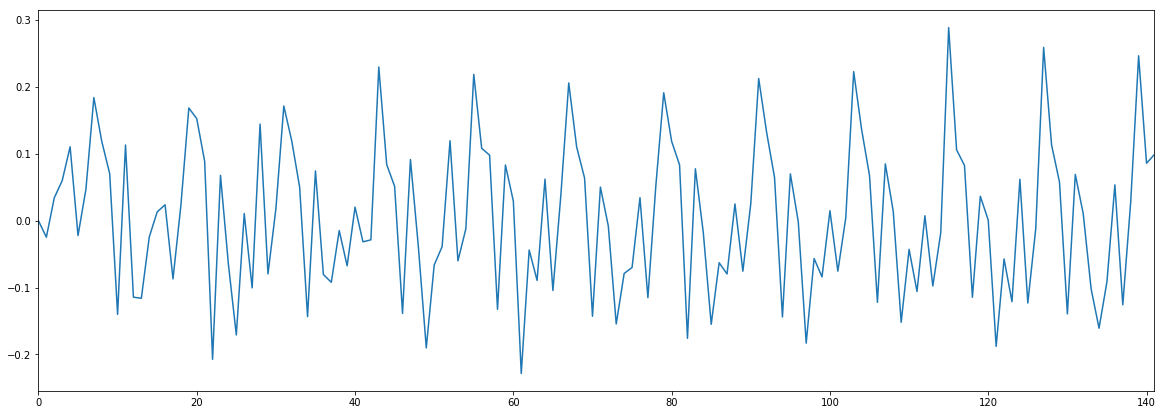

In [75]:
predictions_after_one_diff_and_a_log.plot();

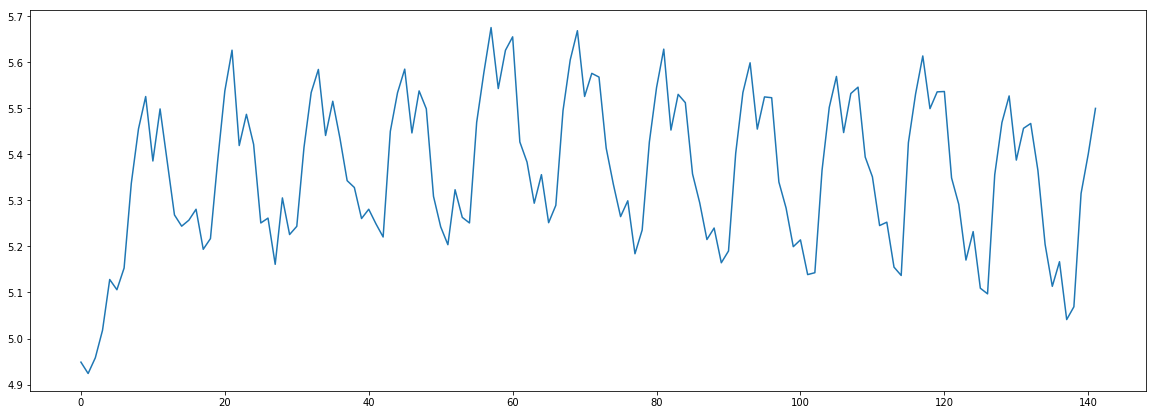

In [85]:
# Huge hack to supress a value error
try:
    predictions_after_a_log.plot();
except ValueError as _:
    pass

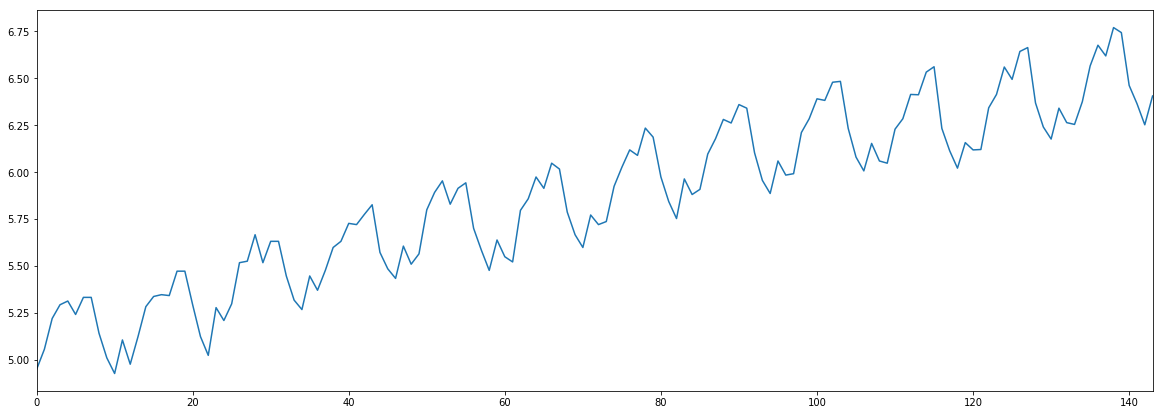

In [80]:
sales_logged.plot();

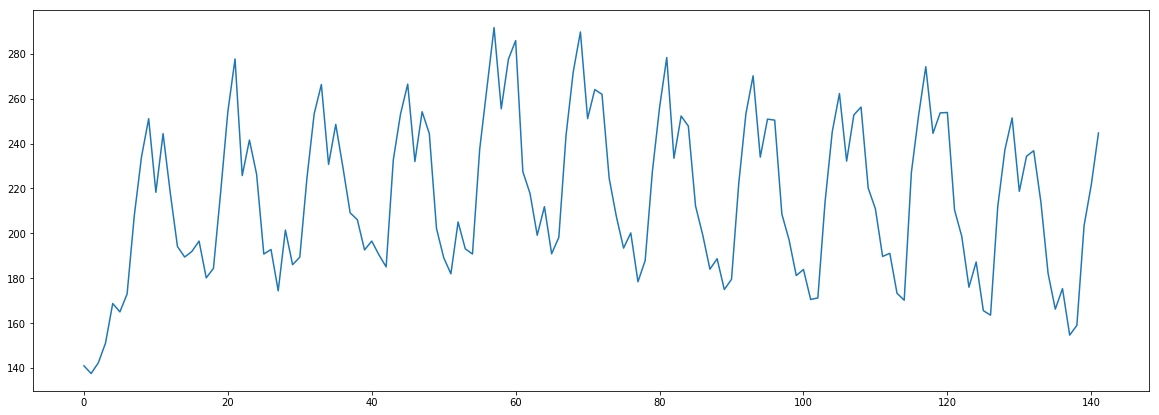

In [86]:
# Huge hack to supress a value error
try:
    predictions.plot()
except ValueError as _:
    pass

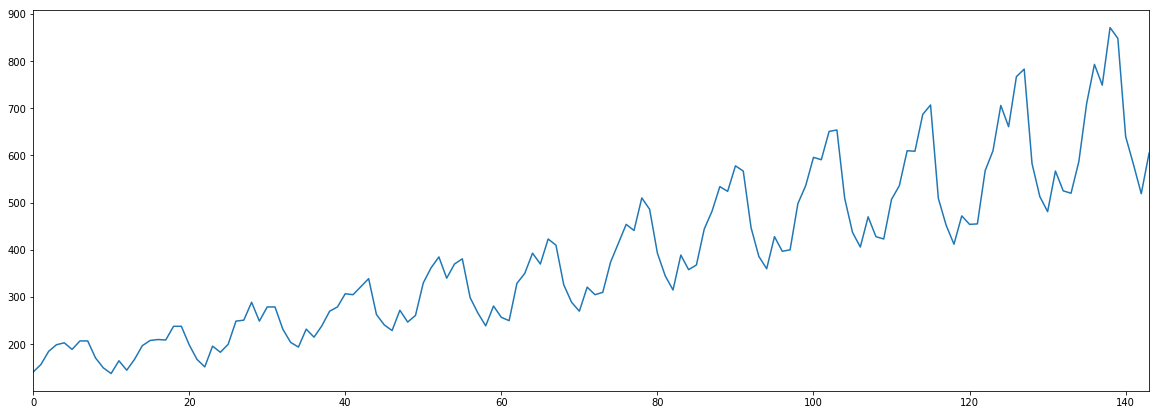

In [81]:
sales.plot();

### What's next? 

Clearly, not a great prediction. Probably the price to pay for our simplified assumptions for the sake of explainability. 

But fear not! This highlty simplified model is quite sufficient to succeed in the exercises, and in the next BLU we will learn how to

* Do some improved pre-processing
* Predict out of sample 
* Introduce seasonality, and exogenous variables. 

But for now, head over to the exercises, which dispite all this apparent complexity, are easy and quite fun!  

----